# 사전 데이터 불러오기 + 합치기

In [1]:
import pandas as pd

df = pd.read_excel('프로젝트/사전/all_keywords.xlsx', index_col=0)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hs_code  134 non-null    int64 
 1   keyword  134 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.1+ KB


In [3]:
df.head()

,hs_code,keyword
0,8401,"['reactor', 'water', 'uranium', 'fuel', 'eleme..."
1,8402,"['boiler', 'steam', 'water', 'vapour', 'heat',..."
2,8403,"['boiler', 'heating boiler', 'heating', 'centr..."
3,8404,"['steam', 'condenser', 'water', 'boiler', 'use..."
4,8405,"['gas', 'water', 'generator', 'gas generator',..."


In [4]:
df = df.set_index('hs_code')

In [5]:
result_dict = df.to_dict()
flattened_dict = {key: inner_value for inner_dict in result_dict.values() for key, inner_value in inner_dict.items()}

# print(flattened_dict)

# 테스트 데이터 불러오기

In [6]:
import pandas as pd
data = pd.read_excel('전처리완료된통합검증데이터.xlsx', index_col=0)

In [7]:
data['hs code'] = data['hs code'].astype(str).str[:4]

In [8]:
data = data.drop_duplicates()

In [9]:
import re
# hs 코드 체크 함수
def check_code(code):
    p = re.compile('8[45]\w*')  # 84로 시작하는 패턴
    m = p.match(code)  # hs코드에서 패턴에 맞는 거 찾기 
    
    if m is None:  # 패턴에 맞지 않는 경우(패턴에 맞지 않으면 none 출력)
        return None  # 패턴에 맞지 않으면 na값으로 반환
    
    else:  # 패턴에 맞는 경우
        return m.group()  # 패턴에 맞는 코드(4자리수) 반환

# hs code 열에 hs 코드 체크 함수 적용
data['hs code'] = data['hs code'].apply(lambda x : check_code(x))

In [10]:
data.dropna(inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1763 entries, 0 to 512
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   hs code   1763 non-null   object
 1   name_des  1763 non-null   object
dtypes: object(2)
memory usage: 41.3+ KB


# 유사도

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
cnt = 0
# HS 코드와 설명서 데이터
hs_code_documents = flattened_dict

# 입력 설명서
for num, input_document in zip(data['hs code'], data['name_des']):

    # HS 코드 문서와 입력 설명서를 하나로 합침
    documents = list(hs_code_documents.values())
    documents.append(input_document)
    # TF-IDF 벡터화 객체 생성
    tfidf = TfidfVectorizer()
    
    # description
    tfidf_matrix = tfidf.fit_transform(documents)
    # 입력 설명서와 각 HS 코드 간의 코사인 유사도 계산
    similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])
    
    # 유사도가 가장 높은 HS 코드 인덱스
    most_similar_hs_code_index = similarities.argmax()
    
    # 유사도가 가장 높은 HS 코드와 유사도 값
    most_similar_hs_code = list(hs_code_documents.keys())[most_similar_hs_code_index]
    similarity_value = similarities[0][most_similar_hs_code_index]

    
    # print(f'원래 HS 코드: {num}', end=" ")
    # print(f"유사: {most_similar_hs_code}")
    # print(f"유사도: {similarity_value}")
    if int(num) == most_similar_hs_code:
        cnt += 1 
print(cnt)

1131


# 전처리 추가

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string

# # 필요한 nltk 데이터 다운로드
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
cnt = 0
# HS 코드와 설명서 데이터
hs_code_documents = flattened_dict

# 입력 설명서
for num, input_document in zip(data['hs code'], data['name_des']):

    # 구두점 제거 함수
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    # 불용어 제거 및 단어의 형태소 분석을 위한 객체 생성
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # 입력 설명서 전처리
    input_document = remove_punctuation(input_document)
    input_tokens = word_tokenize(input_document.lower())  # 소문자로 변환 및 토큰화
    input_tokens = [lemmatizer.lemmatize(word) for word in input_tokens if word not in stop_words]
    
    # HS 코드 문서 전처리
    processed_hs_code_documents = {}
    for code, doc in hs_code_documents.items():
        doc = remove_punctuation(doc)
        tokens = word_tokenize(doc.lower())  # 소문자로 변환 및 토큰화
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        processed_hs_code_documents[code] = ' '.join(tokens)
    
    # TF-IDF 벡터화 객체 생성
    tfidf = TfidfVectorizer()
    documents = list(processed_hs_code_documents.values())
    documents.append(' '.join(input_tokens))  # 입력 설명서를 단일 문자열로 추가
    
    # TF-IDF 벡터화
    tfidf_matrix = tfidf.fit_transform(documents)
    
    # 입력 설명서와 각 HS 코드 간의 코사인 유사도 계산
    similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])
    
    # 유사도가 가장 높은 HS 코드 인덱스
    most_similar_hs_code_index = similarities.argmax()
    
    # 유사도가 가장 높은 HS 코드와 유사도 값
    most_similar_hs_code = list(hs_code_documents.keys())[most_similar_hs_code_index]
    similarity_value = similarities[0][most_similar_hs_code_index]
    
    # print(f'원래 HS 코드: {num}', end=" ")
    # print(f"유사: {most_similar_hs_code}")
    # print(f"유사도: {similarity_value}")
    if int(num) == most_similar_hs_code:
        cnt += 1 
print(cnt)
print((cnt/len(data['hs code']))*100)

1122
63.64152013613159


# 가중치 추가

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string

# # 필요한 nltk 데이터 다운로드
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
cnt = 0
# HS 코드와 설명서 데이터
hs_code_documents = flattened_dict

# 입력 설명서
for num, input_document in zip(data['hs code'], data['name_des']):

    # 구두점 제거 함수
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    # 불용어 제거 및 단어의 형태소 분석을 위한 객체 생성
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # 입력 설명서 전처리
    input_document = remove_punctuation(input_document)
    input_tokens = word_tokenize(input_document.lower())  # 소문자로 변환 및 토큰화
    input_tokens = [lemmatizer.lemmatize(word) for word in input_tokens if word not in stop_words]
    
    # HS 코드 문서 전처리
    processed_hs_code_documents = {}
    for code, doc in hs_code_documents.items():
        doc = remove_punctuation(doc)
        tokens = word_tokenize(doc.lower())  # 소문자로 변환 및 토큰화
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        processed_hs_code_documents[code] = ' '.join(tokens)
    
    # TF-IDF 벡터화 객체 생성
    tfidf = TfidfVectorizer()
    documents = list(processed_hs_code_documents.values())
    tfidf_matrix = tfidf.fit(documents)
    documents.append(' '.join(input_tokens))  # 입력 설명서를 단일 문자열로 추가
    
    # TF-IDF 벡터화
    tfidf_matrix = tfidf.transform(documents)
    # tfidf_matrix[:, tfidf.vocabulary_['solely']] *= 2.0
    # tfidf_matrix[:, tfidf.vocabulary_['principally']] *= 2.0
    # 입력 설명서와 각 HS 코드 간의 코사인 유사도 계산
    similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])
    
    # 유사도가 가장 높은 HS 코드 인덱스
    most_similar_hs_code_index = similarities.argmax()
    
    # 유사도가 가장 높은 HS 코드와 유사도 값
    most_similar_hs_code = list(hs_code_documents.keys())[most_similar_hs_code_index]
    similarity_value = similarities[0][most_similar_hs_code_index]
    
    # print(f'원래 HS 코드: {num}', end=" ")
    # print(f"유사: {most_similar_hs_code}")
    # print(f"유사도: {similarity_value}")
    if int(num) == most_similar_hs_code:
        cnt += 1 
print(cnt)
print((cnt/len(data['hs code']))*100)

1125
63.8116846284742


# 상위 3개

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import numpy as np

# # 필요한 nltk 데이터 다운로드
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
cnt = 0
# HS 코드와 설명서 데이터
hs_code_documents = flattened_dict

# 입력 설명서
for num, input_document in zip(data['hs code'], data['name_des']):

    # 구두점 제거 함수
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    # 불용어 제거 및 단어의 형태소 분석을 위한 객체 생성
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # 입력 설명서 전처리
    input_document = remove_punctuation(input_document)
    input_tokens = word_tokenize(input_document.lower())  # 소문자로 변환 및 토큰화
    input_tokens = [lemmatizer.lemmatize(word) for word in input_tokens if word not in stop_words]
    
    # HS 코드 문서 전처리
    processed_hs_code_documents = {}
    for code, doc in hs_code_documents.items():
        doc = remove_punctuation(doc)
        tokens = word_tokenize(doc.lower())  # 소문자로 변환 및 토큰화
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        processed_hs_code_documents[code] = ' '.join(tokens)
    
    # TF-IDF 벡터화 객체 생성
    tfidf = TfidfVectorizer()
    documents = list(processed_hs_code_documents.values())
    tfidf_matrix = tfidf.fit(documents)
    documents.append(' '.join(input_tokens))  # 입력 설명서를 단일 문자열로 추가
    
    # TF-IDF 벡터화
    tfidf_matrix = tfidf.transform(documents)

    # 입력 설명서와 각 HS 코드 간의 코사인 유사도 계산
    similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])

    
    # 유사도가 가장 높은 상위 3개 HS 코드 인덱스 및 값
    most_similar_hs_code_indices = np.argsort(similarities)[0][-3:][::-1]  # 상위 3개 인덱스
    top_3_similarity_values = similarities[0][most_similar_hs_code_indices] # 상위 3개 유사도 값
    top_3_hs_codes = [list(hs_code_documents.keys())[i] for i in most_similar_hs_code_indices]  # 상위 3개 HS 코드
    
    
    # 원래 HS 코드 출력
    # print(f'원래 HS 코드: {num}', end=" ")
    # print(f"상위 3개 유사도 값: {top_3_similarity_values}")
    # print(f"상위 3개 HS 코드: {top_3_hs_codes}")
    
    # 입력 HS 코드와 유사한 상위 3개 HS 코드 중 일치하는 경우 cnt 증가
    if int(num) in top_3_hs_codes:
        cnt += 1

print(cnt)
print((cnt/len(data['hs code']))*100)

1434
81.33862733976177


In [16]:
import pickle
with open('cosine_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [17]:
import pickle
with open('cosine_dict.pkl', 'wb') as f:
    pickle.dump(processed_hs_code_documents, f)

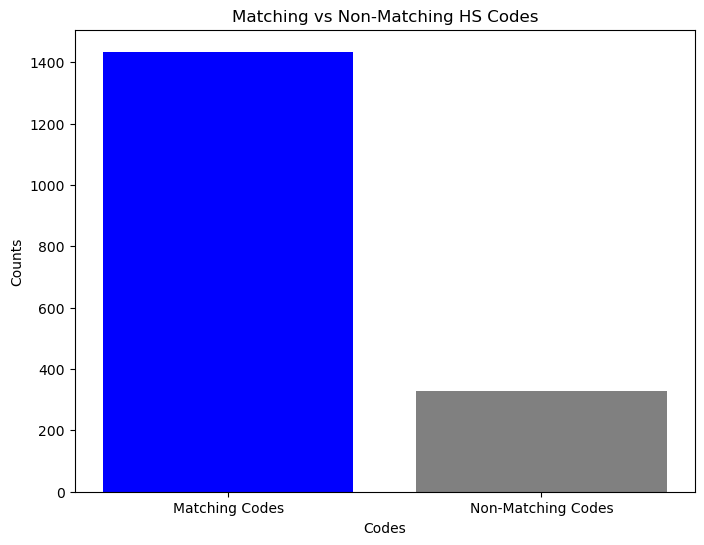

Matching HS Codes: 1434
Non-Matching HS Codes: 329
Matching Percentage: 81.34%


In [18]:
import matplotlib.pyplot as plt

# 일치하는 HS 코드의 수와 비율 계산
total_codes = len(data['hs code'])
matching_codes = cnt
matching_percentage = (matching_codes / total_codes) * 100

# 막대 그래프로 시각화
labels = ['Matching Codes', 'Non-Matching Codes']
values = [matching_codes, total_codes - matching_codes]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'gray'])
plt.xlabel('Codes')
plt.ylabel('Counts')
plt.title('Matching vs Non-Matching HS Codes')
plt.show()

print(f"Matching HS Codes: {matching_codes}")
print(f"Non-Matching HS Codes: {total_codes - matching_codes}")
print(f"Matching Percentage: {matching_percentage:.2f}%")

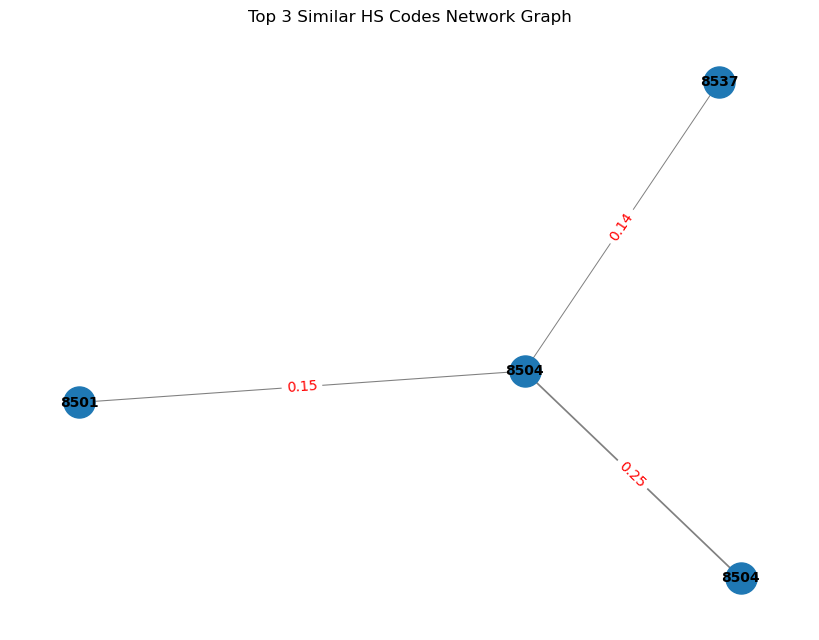

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# 유사도 행렬을 기반으로 네트워크 그래프 생성
G = nx.Graph()
for i, similarity in enumerate(top_3_similarity_values):
    G.add_edge(num, top_3_hs_codes[i], weight=similarity)

# 네트워크 그래프 시각화
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # 레이아웃 설정
edges = G.edges()
weights = [G[u][v]['weight'] * 5 for u, v in edges]  # 가중치 설정
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=500, font_size=10, edge_color='gray', width=weights)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{G[u][v]['weight']:.2f}" for u, v in edges}, font_color='red')
plt.title('Top 3 Similar HS Codes Network Graph')
plt.show()